### Machine Learning Assignment - Naive Bayes and Random Forest
Course code : CMPE-257 
Group name : Codebusters 

- Task Breakdown
    1. Anushri Srinath Aithal(012506897) - Data web scraping, Data Enrichment, KMeans, Linear Regression
    2. Harini Balakrishnan(010830755) - Data preprocessing, GMM, enriched data cleaning
    3. Ravi Katta(012127011) - Visualizations, Random Forest
    4. Sunder Thyagarajan (011528062) - Business Formulation, Naive Bayes, Scraped data cleaning

- Data Story

Classify players that will score >=8 points in a given gameweek based on historical data for previous gameweeks.
Attributes considered ( Total Goals Scored, Total Points, Cleansheets )
In order to build the data set we had to web scrapping of FPL data leverage fantasy.premierleague.com website. 
The site is built using react and we reviewed the XHR calls the network tab to find the services that we could leverage to build our data

DataSet 1 : List of all players and teams that participate in english Premier League
DataSet 2 : Every players scoring history by Gameweek (2018/2019)| (2017/2018)

Join these using the player id and name for market value from other websites

We converted the dataset to a classification problem for every player.

Classification problem : Will a player Score >=8 points ( 1-True, 0-False )
Influential Features : Attributes considered ( Total Goals Scored, Total Points, Cleansheets )

Created 'all_features' which will have list of all features for the previous 7 gameweeks [ X_TRAIN ]
Created 'labels' which will have list of outcomes based on actual score [Y_TRAIN]

INPUT FOR PREDICTION in GW8 : [X_TEST]

#### Load Data using numpy library

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
import requests
from bs4 import BeautifulSoup

fields = ['Name','Team','Position','Cost','Creativity','Influence','Threat','ICT','Goals_conceded','Goals_scored','Assists','Own_goals','Penalties_missed','Penalties_saved','Saves','Yellow_cards','Red_cards','TSB','Minutes','Bonus','Points']
fpl_base_data = pd.read_csv('input_data/fpl/fpl_1.csv', skipinitialspace=True, usecols=fields)
fpl_base_data.head(5)

,Name,Team,Position,Cost,Creativity,Influence,Threat,ICT,Goals_conceded,Goals_scored,...,Own_goals,Penalties_missed,Penalties_saved,Saves,Yellow_cards,Red_cards,TSB,Minutes,Bonus,Points
0,Adam Smith,BOU,DEF,45,345.5,455.0,144.0,94.5,38,1,...,0,0,0,0,6,0,0.3,2067,3,56
1,Adrian,WHU,GKP,45,0.0,470.4,0.0,47.0,29,0,...,0,0,0,69,2,0,0.6,1710,5,72
2,Aguero,MCI,FWD,110,570.8,966.4,1484.0,302.5,12,21,...,0,0,0,0,2,0,12.6,1960,22,169
3,Ake,BOU,DEF,50,115.1,932.4,287.0,133.5,59,2,...,0,0,0,0,5,0,5.7,3352,8,102
4,Albrighton,LEI,MID,55,718.3,580.0,300.0,160.2,42,2,...,0,0,0,0,5,1,1.1,2533,12,107


In [6]:
## ignore warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

#### Data Preprocessing

1. The feature "Name" is broken into "First Name and Last Name" based on space. From the data it is observed that most player last name is present in this data set.
2. All unique team names are fetched as this is required for data enrichment.

In [7]:
fpl_base_data[['first_name','last_name']] = fpl_base_data['Name'].loc[fpl_base_data['Name'].str.split().str.len() == 2].str.split(expand=True)
fpl_base_data.last_name.fillna(fpl_base_data.Name, inplace=True)
fpl_base_data.head(5)

,Name,Team,Position,Cost,Creativity,Influence,Threat,ICT,Goals_conceded,Goals_scored,...,Penalties_saved,Saves,Yellow_cards,Red_cards,TSB,Minutes,Bonus,Points,first_name,last_name
0,Adam Smith,BOU,DEF,45,345.5,455.0,144.0,94.5,38,1,...,0,0,6,0,0.3,2067,3,56,Adam,Smith
1,Adrian,WHU,GKP,45,0.0,470.4,0.0,47.0,29,0,...,0,69,2,0,0.6,1710,5,72,NaN,Adrian
2,Aguero,MCI,FWD,110,570.8,966.4,1484.0,302.5,12,21,...,0,0,2,0,12.6,1960,22,169,NaN,Aguero
3,Ake,BOU,DEF,50,115.1,932.4,287.0,133.5,59,2,...,0,0,5,0,5.7,3352,8,102,NaN,Ake
4,Albrighton,LEI,MID,55,718.3,580.0,300.0,160.2,42,2,...,0,0,5,1,1.1,2533,12,107,NaN,Albrighton


In [8]:
fpl_base_data.Team.unique()

array(['BOU', 'WHU', 'MCI', 'LEI', 'TOT', 'LIV', 'CHE', 'BHA', 'SOU',
       'NEW', 'ARS', 'FUL', 'HUD', 'MUN', 'EVE', 'CAR', 'BUR', 'WOL',
       'CRY', 'WAT'], dtype=object)

#### Data Enrichment and Latent Manifold

1. From the web page https://www.transfermarkt.co.uk scraped team-wise player age and market value
2. Used BeautifulSoup as the html scraper
3. Found the table contents and scraped the age and market value for each player.
4. Stored this in fpl_3.csv file
5. Merged the base data with this new data based on player last name
6. Found some special characters in player name as this is scraped from web. Hence, performed manual cleaning of this to remove special characters and fetch the appropriate last name.
7. After enrichment, the data needed some cleaning. Price had to be stripped off the symbols and converted to float. Age had both date of birth and age. Performed string operations to only extract age and strip of the other characters.
8. Age can be a factor that influences user game. Hence we are considering this as a latent variable in our dataset.

In [45]:
url_list = {"BOU":"https://www.transfermarkt.co.uk/afc-bournemouth/kader/verein/989/saison_id/2018",
            "BHA":"https://www.transfermarkt.co.uk/brighton-amp-hove-albion/kader/verein/1237/saison_id/2018",
            "ARS":"https://www.transfermarkt.co.uk/arsenal-fc/kader/verein/11/saison_id/2018",
            "WHU":"https://www.transfermarkt.co.uk/west-ham-united/kader/verein/379/saison_id/2018",
            "MCI":"https://www.transfermarkt.co.uk/manchester-city/kader/verein/281/saison_id/2018",
            "LEI":"https://www.transfermarkt.co.uk/leicester-city/kader/verein/1003/saison_id/2018",
            "TOT":"https://www.transfermarkt.co.uk/tottenham-hotspur/kader/verein/148/saison_id/2018",
            "LIV":"https://www.transfermarkt.co.uk/fc-liverpool/kader/verein/31/saison_id/2018",
            "CHE":"https://www.transfermarkt.co.uk/fc-chelsea/kader/verein/631/saison_id/2018",
            "SOU":"https://www.transfermarkt.co.uk/fc-southampton/kader/verein/180/saison_id/2018",
            "FUL":"https://www.transfermarkt.co.uk/fc-fulham/kader/verein/931/saison_id/2018",
            "HUD":"https://www.transfermarkt.co.uk/huddersfield-town/kader/verein/1110/saison_id/2018",
            "MUN":"https://www.transfermarkt.co.uk/manchester-united/kader/verein/985/saison_id/2018",
            "EVE":"https://www.transfermarkt.co.uk/fc-everton/kader/verein/29/saison_id/2018",
            "CAR":"https://www.transfermarkt.co.uk/cardiff-city/kader/verein/603/saison_id/2018",
            "BUR":"https://www.transfermarkt.co.uk/fc-burnley/kader/verein/1132/saison_id/2018",
            "WOL":"https://www.transfermarkt.co.uk/wolverhampton-wanderers/kader/verein/543/saison_id/2018",
            "WAT":"https://www.transfermarkt.co.uk/fc-watford/kader/verein/1010/saison_id/2018",
            "NEW":"https://www.transfermarkt.co.uk/newcastle-united/kader/verein/762/saison_id/2018",
            "CRY":"https://www.transfermarkt.co.uk/crystal-palace/kader/verein/873/saison_id/2018"}

#### Web Scraper to fetch Player Age and Market Value

In [46]:
def extract_player_age_market_value():
    player_details = []
    for team_name, request_url in url_list.items():
        page = requests.get(request_url, headers={'User-Agent': 'Mozilla/5.0'})
        soup = BeautifulSoup(page.text, "html.parser")
        for div in soup.find_all(name="div", attrs={"class":"row"}):
            for tab in div.find_all(name="table", attrs={"class":"items"}):
                for tr in tab.find_all(name="tr", attrs={"class":{"odd","even"}}):
                    a = tr.find_all(name="a", attrs={"class":"spielprofil_tooltip"})
                    player_details.append({'Name':a[0].contents[0], 'Age':tr.contents[3].text, 'Market_Value':tr.contents[6].text, 'Team': team_name})
    player_details = pd.DataFrame(player_details)
    return(player_details)

In [6]:
all_team_details = extract_player_age_market_value()
all_team_details = all_team_details.replace({'\u00c4':'A', '\u00e4':'a','\u00cb':'E', '\u00eb':'e','\u00e9':'e','\u00cf':'I', '\u00ef':'i','\u00d6': 'O', 
                                       '\u00f6' : 'o','\u00dc':'U','\u00fc':'u','\u03b2':'ss', 'í':'i','ß': 'ss','á' : 'a', 'à' : 'a','Á':'A', 'ó' : 'o','ã':'a' , 'ø':'o', 
                                       '\u00e0':'a','\u00e2':'a','\u00e6':'a','\u00e8':'e','\u00e9':'e','\u00eA':'e','\u00ee':'i','\u00f4':'o','\u0153':'o','\u00f9':'u',
                                       '\u00fb':'u','\u00ff':'y','\u00e7':'c','\u00c0':'A','\u00c2':'A','\u00c6':'A','\u00c8':'E','\u00c9':'E','\u00ca':'E','\u00ce':'I',
                                       '\u00d4':'O','\u0152':'O','\u00d9':'U','\u00db':'U','\u0178':'Y','\u00c7':'C'}, regex=True)
all_team_details.to_csv('input_data/fpl/fpl_3.csv'.format(os.getcwd()))

#### Data Cleaning

- The enriched data has to be cleaned to convert market value to number, age to number. Also, manually cleaned the names as it contained special characters.

In [9]:
all_team_details = pd.read_csv('input_data/fpl/fpl_3.csv', skipinitialspace=True, usecols=['Age', 'Market_Value', 'Name', 'Team'])
all_team_details.head(5)
all_team_details[['first_name','last_name']] = all_team_details['Name'].loc[all_team_details['Name'].str.split().str.len() == 2].str.split(expand=True)
all_team_details.last_name.fillna(all_team_details.Name, inplace=True)
print(all_team_details['Name'].count())

518


In [10]:
fpl_df = pd.merge(fpl_base_data,all_team_details[['last_name','Team', 'Age', 'Market_Value']], on=['last_name', 'Team'], how='left')

In [11]:
fpl_df = fpl_df.drop_duplicates(subset=['Name'])
fpl_df = fpl_df.drop(columns=['first_name', 'last_name'])
fpl_df = fpl_df[fpl_df['Market_Value'].notnull()]
fpl_df = fpl_df[fpl_df['Age'].notnull()]
print(fpl_df['Name'].count())

399


In [12]:
fpl_df['Market_Value'] = fpl_df['Market_Value'].astype(str)
fpl_df['Market_Value'] = fpl_df['Market_Value'].str.replace("£", "")
fpl_df['Market_Value'] = fpl_df['Market_Value'].str.replace("m", "")
fpl_df['Market_Value'] = fpl_df['Market_Value'].str.replace("k\xa0\xa0", "")
fpl_df['Market_Value'] = fpl_df['Market_Value'].astype(float)
fpl_df.head(5)

,Name,Team,Position,Cost,Creativity,Influence,Threat,ICT,Goals_conceded,Goals_scored,...,Penalties_saved,Saves,Yellow_cards,Red_cards,TSB,Minutes,Bonus,Points,Age,Market_Value
0,Adam Smith,BOU,DEF,45,345.5,455.0,144.0,94.5,38,1,...,0,0,6,0,0.3,2067,3,56,"Apr 29, 1991 (27)",4.5
1,Adrian,WHU,GKP,45,0.0,470.4,0.0,47.0,29,0,...,0,69,2,0,0.6,1710,5,72,"Jan 3, 1987 (31)",4.5
2,Aguero,MCI,FWD,110,570.8,966.4,1484.0,302.5,12,21,...,0,0,2,0,12.6,1960,22,169,"Jun 2, 1988 (30)",72.0
3,Ake,BOU,DEF,50,115.1,932.4,287.0,133.5,59,2,...,0,0,5,0,5.7,3352,8,102,"Feb 18, 1995 (23)",13.5
4,Albrighton,LEI,MID,55,718.3,580.0,300.0,160.2,42,2,...,0,0,5,1,1.1,2533,12,107,"Nov 18, 1989 (28)",9.0


In [13]:
fpl_df['Age'] = fpl_df['Age'].astype(str).str.split(' ').str[-1]
fpl_df['Age'] = fpl_df['Age'].str.replace("(", "")
fpl_df['Age'] = fpl_df['Age'].str.replace(")", "")
fpl_df['Age'] = fpl_df['Age'].astype(int)
fpl_df.head()

,Name,Team,Position,Cost,Creativity,Influence,Threat,ICT,Goals_conceded,Goals_scored,...,Penalties_saved,Saves,Yellow_cards,Red_cards,TSB,Minutes,Bonus,Points,Age,Market_Value
0,Adam Smith,BOU,DEF,45,345.5,455.0,144.0,94.5,38,1,...,0,0,6,0,0.3,2067,3,56,27,4.5
1,Adrian,WHU,GKP,45,0.0,470.4,0.0,47.0,29,0,...,0,69,2,0,0.6,1710,5,72,31,4.5
2,Aguero,MCI,FWD,110,570.8,966.4,1484.0,302.5,12,21,...,0,0,2,0,12.6,1960,22,169,30,72.0
3,Ake,BOU,DEF,50,115.1,932.4,287.0,133.5,59,2,...,0,0,5,0,5.7,3352,8,102,23,13.5
4,Albrighton,LEI,MID,55,718.3,580.0,300.0,160.2,42,2,...,0,0,5,1,1.1,2533,12,107,28,9.0


#### Data Description

In [14]:
fpl_df.describe()

,Cost,Creativity,Influence,Threat,ICT,Goals_conceded,Goals_scored,Assists,Own_goals,Penalties_missed,Penalties_saved,Saves,Yellow_cards,Red_cards,TSB,Minutes,Bonus,Points,Age,Market_Value
count,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000
mean,54.248120,213.966917,329.558396,227.684211,77.108521,19.709273,2.000000,1.779449,0.052632,0.045113,0.047619,4.208020,2.150376,0.077694,3.307018,1374.205514,4.842105,59.558897,26.989975,55.717669
std,13.642458,270.469228,293.513063,329.947865,78.192297,16.898030,3.919414,2.776694,0.283086,0.241374,0.283974,19.052805,2.404444,0.286161,5.795827,1092.600348,6.191470,52.609789,3.946234,174.790387
min,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,1.350000
25%,45.000000,0.000000,38.900000,0.000000,6.700000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.300000,190.000000,0.000000,7.500000,24.000000,4.500000
50%,50.000000,113.400000,296.600000,102.000000,64.300000,18.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.900000,1421.000000,2.000000,55.000000,27.000000,9.000000
75%,55.000000,321.750000,529.600000,304.500000,117.250000,30.500000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,3.650000,2229.500000,8.000000,92.500000,30.000000,22.500000
max,130.000000,1487.000000,1496.200000,2355.000000,454.400000,63.000000,32.000000,17.000000,4.000000,2.000000,3.000000,137.000000,11.000000,2.000000,47.500000,3420.000000,31.000000,303.000000,39.000000,900.000000


#### Co-relation Heat Map
- Draw co-relation heatmap to understand the corelation between various fetaures. From the below we can interpret that Points, ICT (influence, creativity and threat factor) and Cost are highly co-related. 

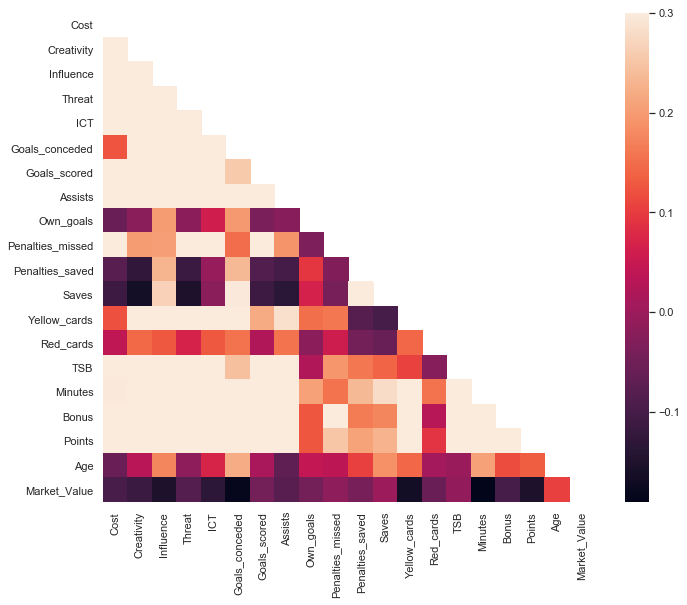

In [15]:
sns.set(style='white')
corr = fpl_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmax=.3)

#### Pairplot 

- Pairplot between all columns to identify the relationship

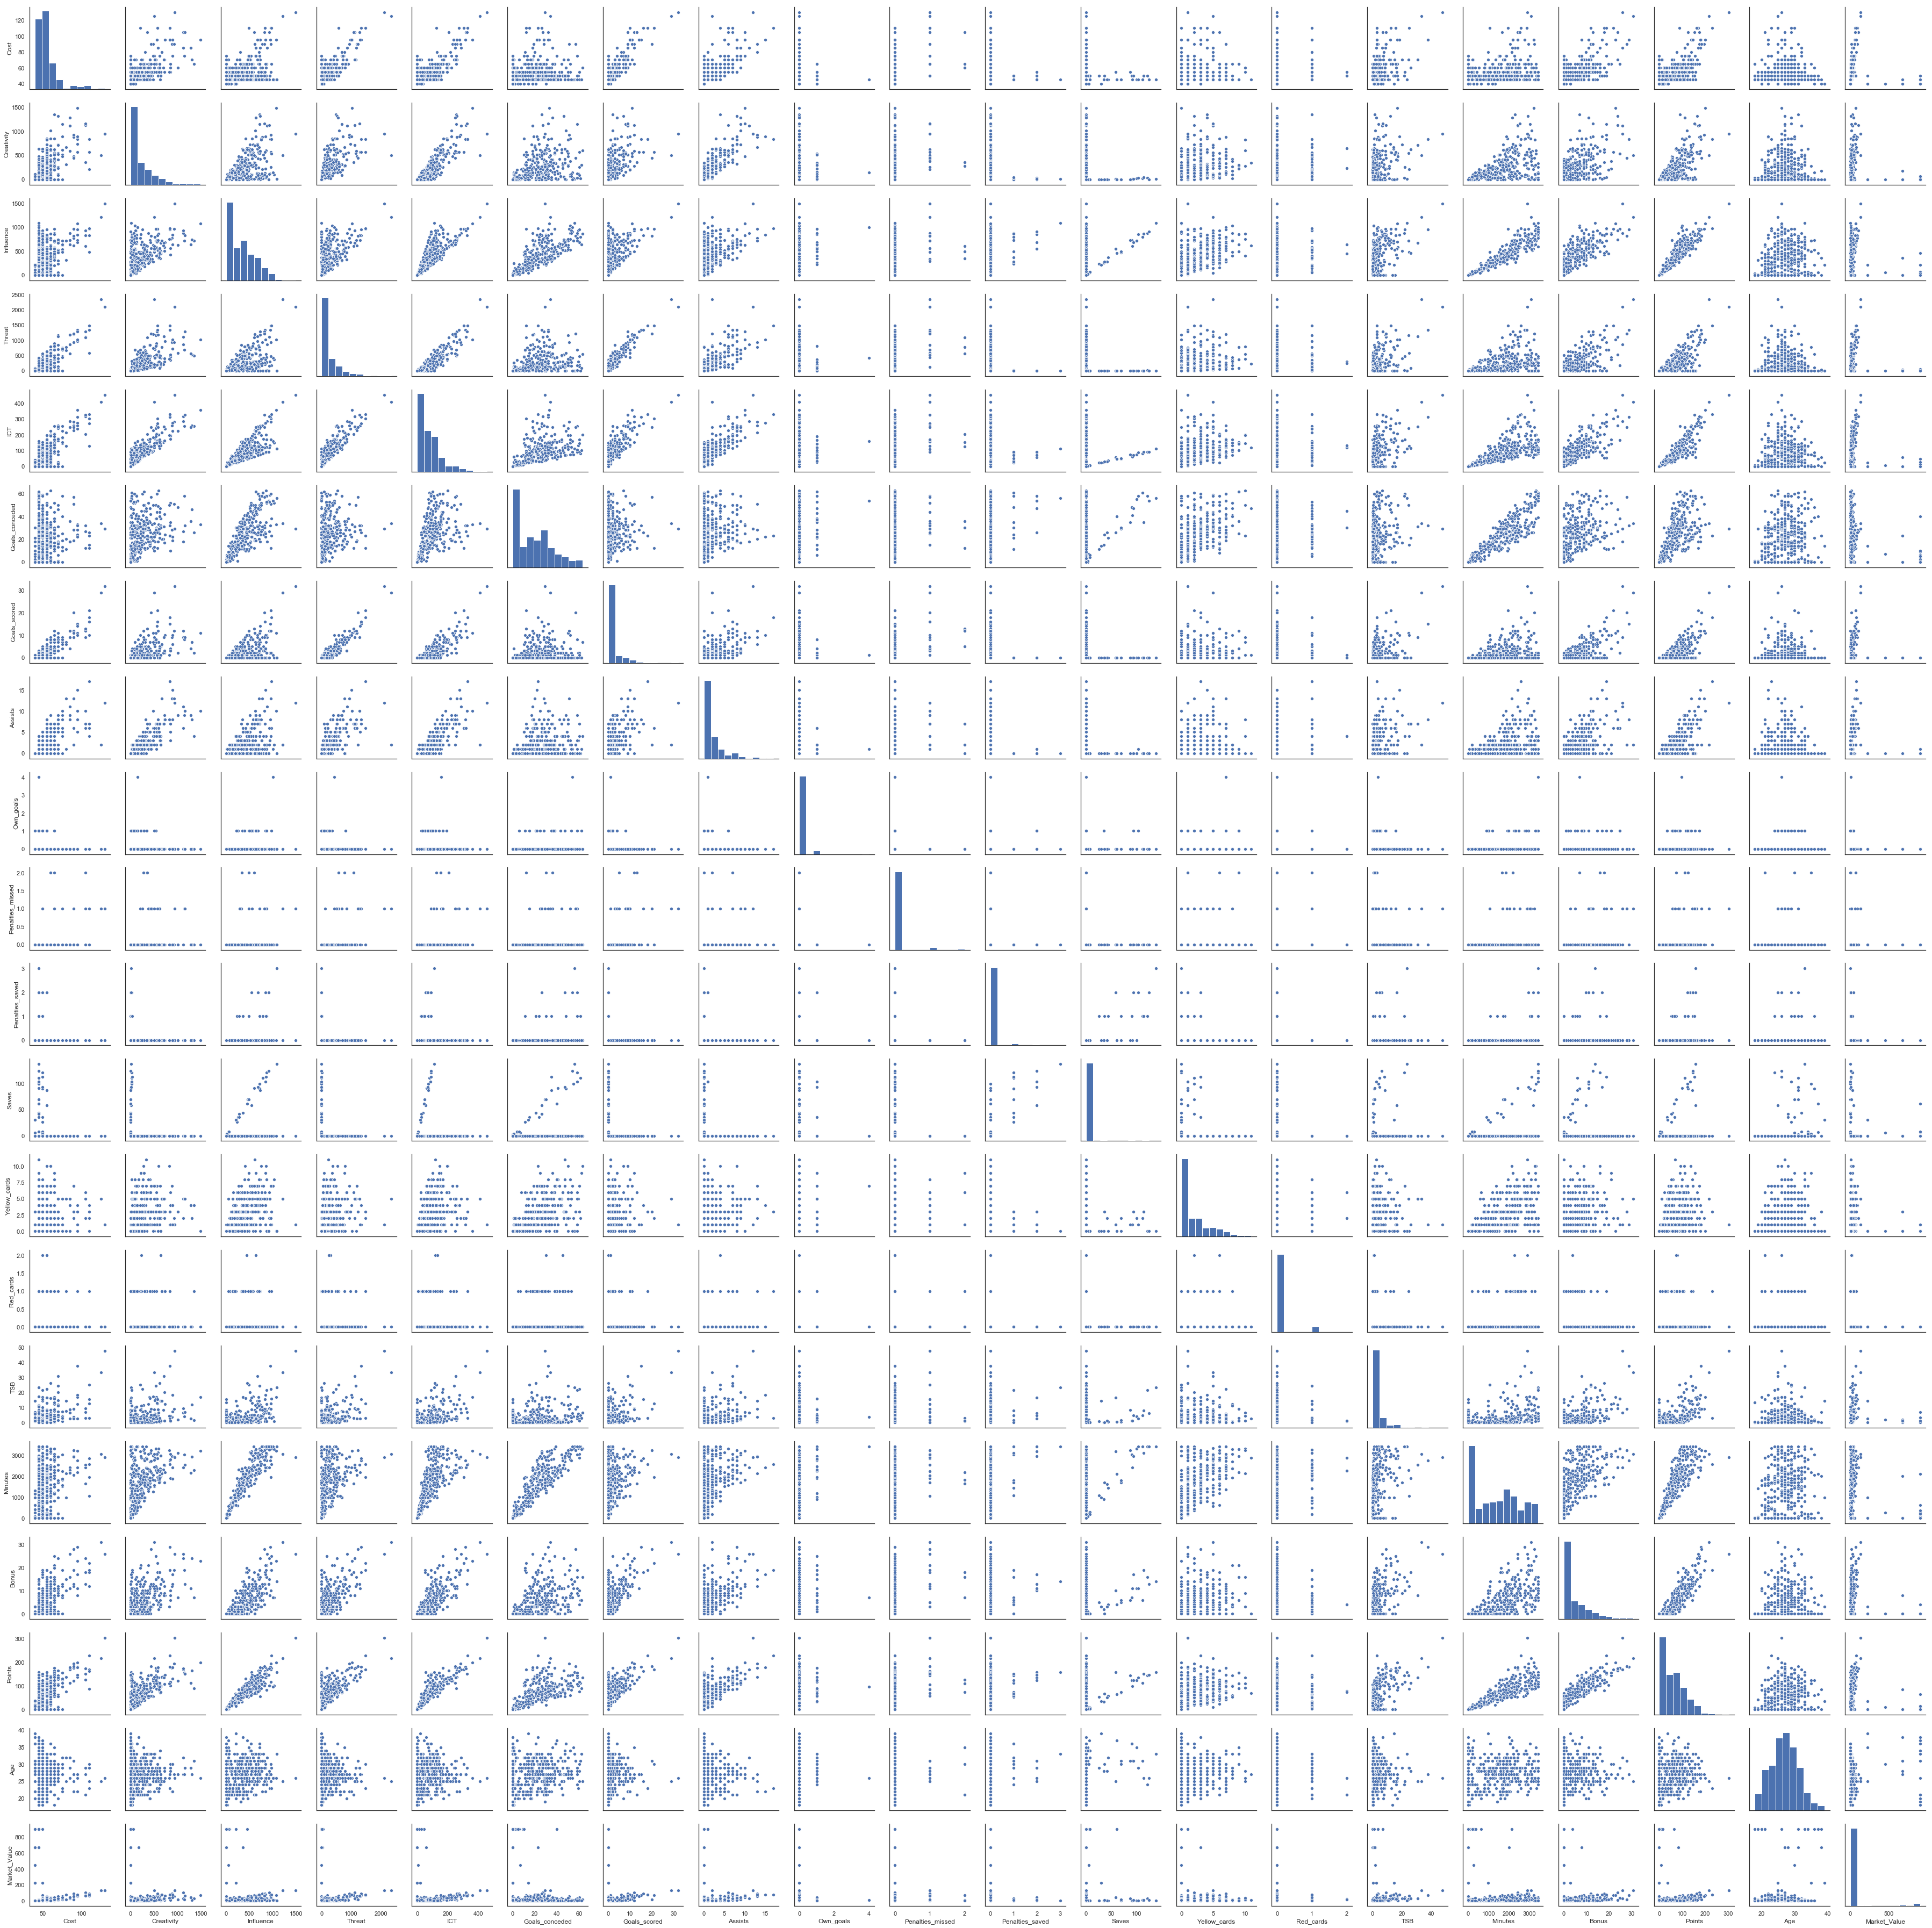

In [16]:
sns.pairplot(fpl_df)

#### Clustering

- Data Story

Applying KMeans clustering to understand how players can be grouped based on ICT value. ICT is a factor of influence, creativity and threat. The points scored by each player is a result of ICT. From the below KMeans application we can group the players as 2 clusters. Low ICT and High ICT

In [17]:
"""#print(fpl_df.count())
from sklearn.preprocessing import StandardScaler
scaled_features = fpl_df.copy()
col_names = ['Age', 'Market_Value']
features = scaled_features[col_names]
scaler = StandardScaler().fit_transform(features.values)
#features = scaler.transform(features.values)
scaled_features[col_names] = features
#print(scaled_features)
#fpl_df[['Age','Market_Value']] = fpl_df[['Age','Market_Value']].apply(lambda x: StandardScaler().fit_transform(x))
#fpl_df.head(5)
f1 = scaled_features['Age'].values
f2 = scaled_features['Market_Value'].values

plt.xlabel('Age')
plt.ylabel('Market_Value')
plt.scatter(f1, f2, c='black', s=7)
plt.show()"""

"#print(fpl_df.count())\nfrom sklearn.preprocessing import StandardScaler\nscaled_features = fpl_df.copy()\ncol_names = ['Age', 'Market_Value']\nfeatures = scaled_features[col_names]\nscaler = StandardScaler().fit_transform(features.values)\n#features = scaler.transform(features.values)\nscaled_features[col_names] = features\n#print(scaled_features)\n#fpl_df[['Age','Market_Value']] = fpl_df[['Age','Market_Value']].apply(lambda x: StandardScaler().fit_transform(x))\n#fpl_df.head(5)\nf1 = scaled_features['Age'].values\nf2 = scaled_features['Market_Value'].values\n\nplt.xlabel('Age')\nplt.ylabel('Market_Value')\nplt.scatter(f1, f2, c='black', s=7)\nplt.show()"

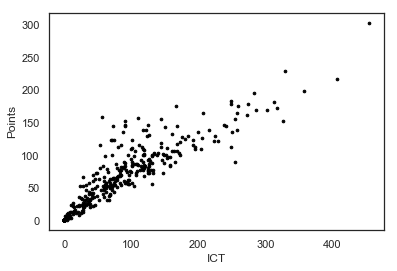

In [18]:
f1 = fpl_df['ICT'].values
f2 = fpl_df['Points'].values

plt.xlabel('ICT')
plt.ylabel('Points')
plt.scatter(f1, f2, c='black', s=7)
plt.show()

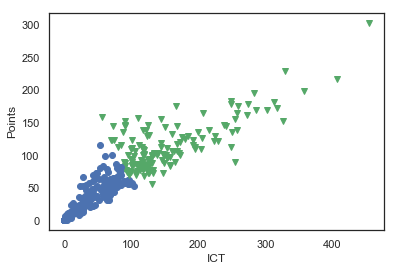

In [19]:
from sklearn.cluster import KMeans

M=np.matrix(list(zip(f1, f2)))
kmeans = KMeans(n_clusters=2).fit(M)
#centers = kmeans.cluster_centers_
y_pred = kmeans.predict(M)

colors = ['b', 'g', 'm', 'y', 'c']
markers = ['o', 'v', 'x', 'o', 's']
#center_colors = colors[:len(y_pred)]

plt.xlabel('ICT')
plt.ylabel('Points')
for i, l in enumerate(kmeans.labels_):
    plt.plot(f1[i], f2[i], color=colors[l], marker=markers[l],ls='None')

#### Gaussian Mixture Model

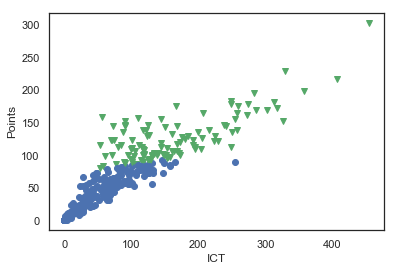

In [23]:
import warnings
from sklearn.mixture import GaussianMixture

warnings.filterwarnings("ignore", category=DeprecationWarning)

M=np.matrix(list(zip(f1, f2)))
gmm = GaussianMixture(n_components=2,  covariance_type='tied', random_state=0).fit(M)
labels = gmm.predict(M)

plt.xlabel('ICT')
plt.ylabel('Points')

for i, l in enumerate(labels):
    plt.plot(f1[i], f2[i], color=colors[l], marker=markers[l],ls='None')

#### Linear Regression

- Data Story

In this we are trying to predict the points a player will score based on his ICT value. From the pairplot we notice that ICT and points are lineraly related. Predicting the points a player will score enables the team to identify the best possible winning team combination for a given week.Applying linear regression on ICT and Points to predict the points player might score.

In [24]:
X = fpl_df[['ICT']]
y = fpl_df[['Points']]

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

regression_model = LinearRegression()
regression_model.fit(X_train, y_train)
regression_model.score(X_test, y_test)

0.8213529249888842

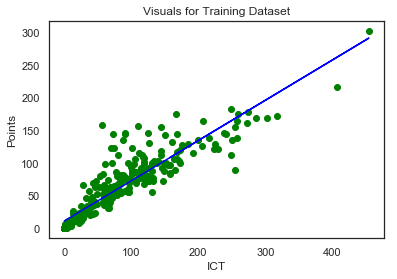

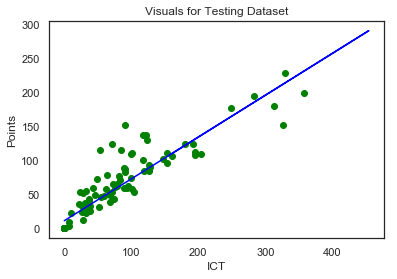

In [27]:
y_pred = regression_model.predict(X_test) 

#Visualizing the training Test Results 
plt.scatter(X_train, y_train, color= 'green')
plt.plot(X_train, regression_model.predict(X_train), color = 'blue')
plt.title ("Visuals for Training Dataset")
plt.xlabel("ICT")
plt.ylabel("Points")
plt.show()

#Visualizing the Test Results 
plt.scatter(X_test, y_test, color= 'green')
plt.plot(X_train, regression_model.predict(X_train), color = 'blue')
plt.title ("Visuals for Testing Dataset")
plt.xlabel("ICT")
plt.ylabel("Points")
plt.show()

#### Data Enrichment
- Enrich the fpl 2017 data with 2018 and 2019 scores, points, ict and clean sheets for further analysis

In [53]:
def extract_player_ids():
    url = "https://fantasy.premierleague.com/drf/bootstrap-static"
    response  = requests.get(url)
    data = json.loads(response.text)
    all_players = data['elements']

    player_ids = {}
    for player in all_players:
        player_ids[player['id']] = player['web_name']
    return(player_ids)

In [54]:
def extract_gameweek_scores():
    player_ids = extract_player_ids()
    player_details = []
    for player in player_ids:
        details = {}
        url = "https://fantasy.premierleague.com/drf/element-summary/" + str(player)
        response  = requests.get(url)
        data = json.loads(response.text)
        history = data['history']
        #print(value)
        details['Name'] = player_ids[player]
        details['Player_Id'] = player
        count = 1
        for value in history:
            #print([int(value['goals_scored']), int(value['total_points']),int(value['clean_sheets']),float(value['ict_index'])])
            s = str(count)
            details['goals_scored_GW'+s] = value['goals_scored']
            details['total_points_GW'+s] = value['total_points']
            details['clean_sheets_GW'+s] = value['clean_sheets']
            details['ict_index_GW'+s] = value['ict_index']
            details['bps_GW'+s] = value['bps']
            details['bonus_GW'+s] = value['bps']
            details['saves_GW'+s] = value['saves']
            #details.append({'goals_scored_GW'+s:value['goals_scored'], 'total_points_GW'+s:value['total_points'], 'clean_sheets_GW'+s:value['clean_sheets'], 
                                  # 'ict_index_GW'+s:value['ict_index']})
            count = count + 1
        player_details.append(details)
    player_details = pd.DataFrame(player_details)
    #print(player_details)
    return(player_details)

In [55]:
fpl_201819 = extract_gameweek_scores()
fpl_201819 = fpl_201819.replace({'\u00c4':'A', '\u00e4':'a','\u00cb':'E', '\u00eb':'e','\u00e9':'e','\u00cf':'I', '\u00ef':'i','\u00d6': 'O', 
                                       '\u00f6' : 'o','\u00dc':'U','\u00fc':'u','\u03b2':'ss', 'í':'i','ß': 'ss','á' : 'a', 'à' : 'a','Á':'A', 'ó' : 'o','ã':'a' , 'ø':'o', 
                                       '\u00e0':'a','\u00e2':'a','\u00e6':'a','\u00e8':'e','\u00e9':'e','\u00eA':'e','\u00ee':'i','\u00f4':'o','\u0153':'o','\u00f9':'u',
                                       '\u00fb':'u','\u00ff':'y','\u00e7':'c','\u00c0':'A','\u00c2':'A','\u00c6':'A','\u00c8':'E','\u00c9':'E','\u00ca':'E','\u00ce':'I',
                                       '\u00d4':'O','\u0152':'O','\u00d9':'U','\u00db':'U','\u0178':'Y','\u00c7':'C'}, regex=True)
fpl_201819.to_csv('input_data/fpl/fpl_2018_19.csv'.format(os.getcwd()))

In [56]:
fpl_df2 = pd.merge(fpl_df,fpl_201819, on=['Name'], how='left')

In [58]:
print(fpl_df2['Name'].count())
fpl_df2.head(5)

414


,Name,Team,Position,Cost,Creativity,Influence,Threat,ICT,Goals_conceded,Goals_scored,...,saves_GW9,total_points_GW1,total_points_GW2,total_points_GW3,total_points_GW4,total_points_GW5,total_points_GW6,total_points_GW7,total_points_GW8,total_points_GW9
0,Adam Smith,BOU,DEF,45,345.5,455.0,144.0,94.5,38,1,...,0.0,6,2.0,-2.0,2.0,7.0,1.0,2.0,6.0,6.0
1,Adrian,WHU,GKP,45,0.0,470.4,0.0,47.0,29,0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aguero,MCI,FWD,110,570.8,966.4,1484.0,302.5,12,21,...,0.0,2,20.0,2.0,6.0,7.0,6.0,8.0,1.0,6.0
3,Ake,BOU,DEF,50,115.1,932.4,287.0,133.5,59,2,...,0.0,8,2.0,8.0,1.0,1.0,0.0,2.0,6.0,6.0
4,Albrighton,LEI,MID,55,718.3,580.0,300.0,160.2,42,2,...,0.0,0,1.0,4.0,2.0,6.0,1.0,1.0,1.0,0.0


In [59]:
fpl_df2.to_csv('input_data/fpl/all_fpl_new.csv'.format(os.getcwd()))

#### Naive Bayes

- Data Story

The data story is to predict if a player will score more than or equal to 8 points in a certain gameweek. This will allow the FPL manager to identify players they want to transfer in or out for a certain week. This also helps in identifying the captain. In FPL more than 7 points is a decent score.

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

all_fpl = pd.read_csv('input_data/fpl/all_fpl_new.csv')
all_fpl = all_fpl[all_fpl['Name']!='Deulofeu']
all_fpl = all_fpl.fillna(0)

In [70]:
np.seterr(divide='ignore', invalid='ignore')
gameweeks = [1,2,3,4,5,6,7,8]
predict_labels = []
actual_labels = []
actual_players = []
predict_players = []

for index, row in all_fpl.iterrows():
    all_features = []
    labels = []
    #print (row['Name'])
    for j in gameweeks:
        features = [int(row['goals_scored_GW'+str(j)]),int(row['clean_sheets_GW'+str(j)]),int(row['bonus_GW'+str(j)]),int(row['bps_GW'+str(j)]),int(row['saves_GW'+str(j)])]
        #print (j, ':',features)
        all_features.append(features)
        if int(row['total_points_GW'+str(j)])>=8:
            labels.append(1)
        else:
            labels.append(0)

    x_train = all_features
    y_train = labels
    
    j=7
    y_test = []
    x_test = [[int(row['goals_scored_GW'+str(j)]),int(row['clean_sheets_GW'+str(j)]),int(row['bonus_GW'+str(j)]),int(row['bps_GW'+str(j)]),int(row['saves_GW'+str(j)])]]
    if int(row['total_points_GW'+str(j+1)])>=8:
        y_test.append(1)
        actual_players.append(row['Name'])
    else:
        y_test.append(0)
    
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)

# GaussianNB Regression Model Fitting
    clf = GaussianNB()
    clf.fit(x_train,y_train)
        
    y_pred = clf.predict(x_test)
    
    actual_labels.append(y_test)
    predict_labels.append(y_pred)
    if y_pred == 1:
        predict_players.append(row['Name']) 
    #print(row['Name'],y_pred)
    
    #print (row['Name'],":Scored More than 3 points:",y_pred,":Accuracy:",accuracy_score(y_test,y_pred))

In [71]:
accuracy_score(actual_labels,predict_labels)

0.9200968523002422

In [72]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(actual_labels, predict_labels)
print(cm)

[[375  15]
 [ 18   5]]


In [74]:
print("Actual Players who scored more than 8 points")
print(actual_players)
print(len(actual_players))

print("Predicted Players who scored more than 8 points")
print(predict_players)
print(len(predict_players))

set(actual_players).intersection(predict_players)

Actual Players who scored more than 8 points
['Aubameyang', 'Barkley', 'Brooks', 'Dier', 'Doherty', 'Hazard', 'Kenedy', 'King', 'Lacazette', 'Lloris', 'Lovren', 'Martial', 'Mata', 'Murray', 'Patricio', 'Ramsey', 'Ryan', 'Schindler', 'Sigurdsson', 'Stones', 'Sanchez', 'Vokes', 'Wilson']
23
Predicted Players who scored more than 8 points
['Arnautovic', 'Bellerin', 'Coady', 'Doherty', 'Felipe Anderson', 'Hazard', 'Holding', 'Kane', 'Keane', 'Maguire', 'Murphy', 'Patricio', 'Rose', 'Sigurdsson', 'Stanislas', 'Sterling', 'Vardy', 'Vokes', 'Zabaleta', 'Ozil']
20


{'Doherty', 'Hazard', 'Patricio', 'Sigurdsson', 'Vokes'}

In [77]:
### Predicting for 10th Gameweek
np.seterr(divide='ignore', invalid='ignore')
gameweeks = [1,2,3,4,5,6,7,8]
predict_labels = []
actual_labels = []
actual_players = []
predict_players = []

for index, row in all_fpl.iterrows():
    all_features = []
    labels = []
    #print (row['Name'])
    for j in gameweeks:
        features = [int(row['goals_scored_GW'+str(j)]),int(row['clean_sheets_GW'+str(j)]),int(row['bonus_GW'+str(j)]),int(row['bps_GW'+str(j)]),int(row['saves_GW'+str(j)])]
        #print (j, ':',features)
        all_features.append(features)
        if int(row['total_points_GW'+str(j)])>=8:
            labels.append(1)
        else:
            labels.append(0)

    x_train = all_features
    y_train = labels
    
    j=9
    y_test = []
    x_test = [[int(row['goals_scored_GW'+str(j)]),int(row['clean_sheets_GW'+str(j)]),int(row['bonus_GW'+str(j)]),int(row['bps_GW'+str(j)]),int(row['saves_GW'+str(j)])]]
    """if int(row['total_points_GW'+str(j+1)])>=8:
        y_test.append(1)
        actual_players.append(row['Name'])
    else:
        y_test.append(0)"""
    
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
   # y_test = np.array(y_test)

# GaussianNB Regression Model Fitting
    clf = GaussianNB()
    clf.fit(x_train,y_train)
        
    y_pred = clf.predict(x_test)
    
    """actual_labels.append(y_test)
    predict_labels.append(y_pred)
    if y_pred == 1:
        predict_players.append(row['Name']) """
    if y_pred == 1:
        print(row['Name'],y_pred)
    
    #print (row['Name'],":Scored More than 3 points:",y_pred,":Accuracy:",accuracy_score(y_test,y_pred))

Bernardo Silva [1]
Lovren [1]
Mendy [1]
Pereyra [1]
Salah [1]
Stones [1]
Wilson [1]


#### Random Forest

- Data Story

The data story is to predict if a player will score more than or equal to 8 points in a certain gameweek. This will allow the FPL manager to identify players they want to transfer in or out for a certain week. This also helps in identifying the captain. In FPL more than 7 points is a decent score.

In [79]:
from sklearn.ensemble import RandomForestClassifier

np.seterr(divide='ignore', invalid='ignore')
gameweeks = [1,2,3,4,5,6,7,8]
predict_labels = []
actual_labels = []
actual_players = []
predict_players = []

for index, row in all_fpl.iterrows():
    all_features = []
    labels = []
    #print (row['Name'])
    for j in gameweeks:
        features = [int(row['goals_scored_GW'+str(j)]),int(row['clean_sheets_GW'+str(j)]),int(row['bonus_GW'+str(j)]),int(row['bps_GW'+str(j)]),int(row['saves_GW'+str(j)])]
        #print (j, ':',features)
        all_features.append(features)
        if int(row['total_points_GW'+str(j)])>=8:
            labels.append(1)
        else:
            labels.append(0)

    x_train = all_features
    y_train = labels
    
    j=7
    y_test = []
    x_test = [[int(row['goals_scored_GW'+str(j)]),int(row['clean_sheets_GW'+str(j)]),int(row['bonus_GW'+str(j)]),int(row['bps_GW'+str(j)]),int(row['saves_GW'+str(j)])]]
    if int(row['total_points_GW'+str(j+1)])>=8:
        y_test.append(1)
        actual_players.append(row['Name'])
    else:
        y_test.append(0)
    
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)

# Random Forest Model Fitting
    random_tree = RandomForestClassifier(n_estimators=100, random_state=0)
    random_tree.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    
    actual_labels.append(y_test)
    predict_labels.append(y_pred)
    if y_pred == 1:
        predict_players.append(row['Name']) 
    #print(row['Name'],y_pred)
    
    #print (row['Name'],":Scored More than 3 points:",y_pred,":Accuracy:",accuracy_score(y_test,y_pred))

In [81]:
accuracy_score(actual_labels,predict_labels)

0.9200968523002422

In [82]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(actual_labels, predict_labels)
print(cm)

[[376  14]
 [ 19   4]]


In [83]:
print("Actual Players who scored more than 8 points")
print(actual_players)
print(len(actual_players))

print("Predicted Players who scored more than 8 points")
print(predict_players)
print(len(predict_players))

Actual Players who scored more than 8 points
['Aubameyang', 'Barkley', 'Brooks', 'Dier', 'Doherty', 'Hazard', 'Kenedy', 'King', 'Lacazette', 'Lloris', 'Lovren', 'Martial', 'Mata', 'Murray', 'Patricio', 'Ramsey', 'Ryan', 'Schindler', 'Sigurdsson', 'Stones', 'Sanchez', 'Vokes', 'Wilson']
23
Predicted Players who scored more than 8 points
['Aguero', 'Arnautovic', 'Brooks', 'Cavaleiro', 'Felipe Anderson', 'Hazard', 'Kane', 'Maguire', 'Murphy', 'Rashford', 'Sigurdsson', 'Stanislas', 'Sterling', 'Sturridge', 'Tosun', 'Vardy', 'Vokes', 'Ozil']
18
